<a href="https://colab.research.google.com/github/bodadaniel/CNN/blob/main/VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##VGG16 Architecture

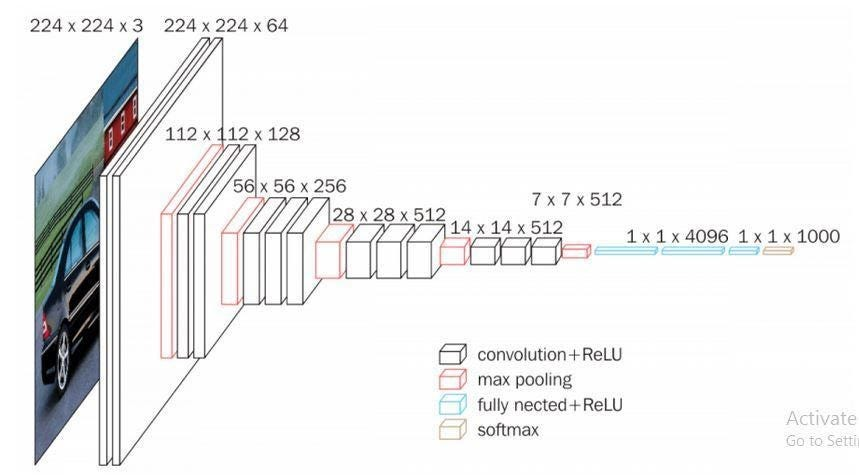
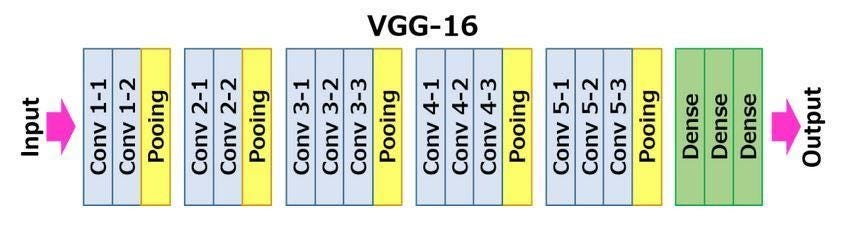

Sources:

https://arxiv.org/pdf/1409.1556.pdf

https://medium.com/@mygreatlearning/everything-you-need-to-know-about-vgg16-7315defb5918

##Import packages & load data

In [ ]:
import numpy as np
import torch
from torch import nn, optim
from torchvision import datasets, transforms
!pip install torchmetrics
import torchmetrics
from torchsummary import summary

import matplotlib.pyplot as plt
from datetime import datetime

In [ ]:
#Transformation for both train and validation dataset
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize((224,224)),
                                transforms.Normalize(mean = (0.5, 0.5, 0.5), std = (0.2, 0.2, 0.2))
                                #transforms.RandomHorizontalFlip(p = 0.5),
                                #transforms.RandomCrop((32, 32), padding = 4, fill = 0)
                                ])

val_transform = transforms.Compose([transforms.ToTensor(),
                                    transforms.Resize((224,224)),
                                    transforms.Normalize(mean = (0.5, 0.5, 0.5), std = (0.2, 0.2, 0.2))
                                    ])

# Build the train loader
train_loader = torch.utils.data.DataLoader(datasets.CIFAR10('./data',
                                                            download = True,
                                                            train = True,
                                                            transform = transform),
                                           batch_size = 64,
                                           shuffle = True)

# Build the validation loader
val_loader = torch.utils.data.DataLoader(datasets.CIFAR10('./data',
                                                          download = True,
                                                          train = True,
                                                          transform = val_transform),
                                        batch_size = 64,
                                         shuffle = True)

# Build the test loader
test_loader = torch.utils.data.DataLoader(datasets.CIFAR10('./data',
                                                           download = True,
                                                           train = False,
                                                           transform = val_transform),
                                          batch_size = 64,
                                          shuffle = False)

100%|██████████| 170498071/170498071 [00:01<00:00, 96660862.30it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Files already downloaded and verified


## Plotting functions

In [ ]:

def plot_loss(train_losses, valid_losses):
  """ Plotting function for loss """
  fig = plt.figure(figsize=(10,6))
  ax = fig.add_subplot(1,1,1)
  ax.plot(np.arange(1, len(train_losses) + 1, 1), train_losses, label='Train loss', color = 'blue')
  ax.plot(np.arange(1, len(valid_losses) + 1, 1), valid_losses, label='Valid loss', color = 'green')
  plt.legend()
  ax.set_xlabel('Epoch')
  ax.set_ylabel('Loss')
  ax.set_title(f'Loss function (epoch)')

plot_loss(train_losses = np.arange(0.5, 1, 0.05), valid_losses = np.arange(0, 0.5, 0.05))

def plot_accuracy(train_accuracy, valid_accuracy):
  """ Plotting function for accuracy """
  fig = plt.figure(figsize=(10,6))
  ax = fig.add_subplot(1,1,1)
  ax.plot(np.arange(1, len(train_accuracy) + 1, 1), train_accuracy, label='Train accuracy', color = 'blue')
  ax.plot(np.arange(1, len(valid_accuracy) + 1, 1), valid_accuracy, label='Valid accuracy', color = 'green')
  plt.legend()
  ax.set_xlabel('Epoch')
  ax.set_ylabel('Accuracy')
  ax.set_title(f'Accuracy (epoch)')

plot_accuracy(train_accuracy = np.arange(0.5, 1, 0.05), valid_accuracy = np.arange(0, 0.5, 0.05))

##The model

In [ ]:
class ConvBlock(nn.Module):
  """ Bulding convolution block """

  def __init__(self, size = 1, in_channels = 3, out_channels = 64, pooling = False):
    super(ConvBlock, self).__init__()

    self.conv_block = list()
    self.max_pooling = nn.MaxPool2d(kernel_size = 2, stride = 2)
    self.act_func = nn.ReLU()

    if pooling:
      self.conv_block.append(self.max_pooling)

    for i in range(size - 1):
      self.conv_block.append(nn.Conv2d(in_channels = in_channels if i == 0 else out_channels,
                                       out_channels = out_channels,
                                       kernel_size = 3,
                                       stride = 1,
                                       padding='same',
                                       padding_mode='zeros'
                                       )
                              )
      self.conv_block.append(self.act_func)

    self.conv_block = nn.Sequential(*self.conv_block)

  def forward(self, x):
    return self.conv_block(x)


In [ ]:
#Testing
Net = ConvBlock(size = 3, pooling = True)
print(Net)
x = torch.rand(1, 3, 224, 224)
print('orig:', x.size())
print('after:', Net.forward(x).size())

ConvBlock(
  (max_pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (act_func): ReLU()
  (conv_block): Sequential(
    (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): ReLU()
  )
)
orig: torch.Size([1, 3, 224, 224])
after: torch.Size([1, 64, 112, 112])


In [ ]:
#Testing
summary(ConvBlock(size = 2, pooling = True), input_size=(3, 224, 224), device = 'cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         MaxPool2d-1          [-1, 3, 112, 112]               0
         MaxPool2d-2          [-1, 3, 112, 112]               0
            Conv2d-3         [-1, 64, 112, 112]           1,792
              ReLU-4         [-1, 64, 112, 112]               0
              ReLU-5         [-1, 64, 112, 112]               0
Total params: 1,792
Trainable params: 1,792
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 18.95
Params size (MB): 0.01
Estimated Total Size (MB): 19.53
----------------------------------------------------------------


In [ ]:
class ConvModel(nn.Module):
  """ Build the model from blocks """

  def __init__(self, s_size = 32, num_labels = 100):
    super(ConvModel, self).__init__()

    """
    self.first_conv = nn.Conv2d(in_channels = 3,
                                       out_channels = 64,
                                       kernel_size = 3,
                                       stride = 1,
                                       padding='same',
                                       padding_mode='zeros'
                                       )
    """

    self.first_conv = ConvBlock(size = 3, in_channels = 3, out_channels = 64, pooling = False)

    self.second_conv = ConvBlock(size = 3, in_channels = 64, out_channels = 128, pooling = True)

    self.third_conv = ConvBlock(size = 4, in_channels = 128, out_channels = 256, pooling = True)

    self.fourth_conv = ConvBlock(size = 4, in_channels = 256, out_channels = 512, pooling = True)

    self.fifth_conv = ConvBlock(size = 4, in_channels = 512, out_channels = 512, pooling = True)

    self.max_pooling = nn.MaxPool2d(kernel_size=2)

    self.relu = nn.ReLU()

    self.dropout = nn.Dropout(p=0.5)

    self.fc1 = (nn.Linear(in_features = 7 * 7 * 512, out_features = 4096))
    self.fc2 = (nn.Linear(in_features = 4096, out_features = 4096))
    self.fc3 = (nn.Linear(in_features = 4096, out_features = num_labels))

    #self.softmax = nn.Softmax(dim = 1)

  def forward(self, x):
    #print(x.size())
    x = self.first_conv(x)
    #print(x.size())
    x = self.second_conv(x)
    #print(x.size())
    x = self.third_conv(x)
    #print(x.size())
    x = self.fourth_conv(x)
    #print(x.size())
    x = self.fifth_conv(x)
    #print(x.size())
    x = self.max_pooling(x)
    x = x.view(-1, (x.size(1) *  x.size(2) * x.size(3)) )
    #print(x.size())
    x = self.dropout(x)
    x = self.fc1(x)
    x = self.relu(x)
    #print(x.size())
    x = self.dropout(x)
    x = self.fc2(x)
    x = self.relu(x)
    #print(x.size())
    x = self.fc3(x)
    x = self.relu(x)
    #print(x.size())
    return x

In [ ]:
#The network with spatial size of 224 x 224
Net_model = ConvModel(s_size = 224)
print(Net_model)

ConvModel(
  (first_conv): ConvBlock(
    (max_pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (act_func): ReLU()
    (conv_block): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (1): ReLU()
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (3): ReLU()
    )
  )
  (second_conv): ConvBlock(
    (max_pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (act_func): ReLU()
    (conv_block): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (2): ReLU()
      (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (4): ReLU()
    )
  )
  (third_conv): ConvBlock(
    (max_pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (act_func): ReLU()
    (conv_block)

In [ ]:
#Testing
x = torch.rand(2, 3, 224, 224)
print('orig:', x.size())
print('after:', Net_model.forward(x).size())

orig: torch.Size([2, 3, 224, 224])
after: torch.Size([2, 100])


## Train

In [ ]:
def train(model, train_data, val_data, criterion, optimizer, epochs = 1, cuda = False, lr_scheduler = None):
    """ Function for training the net"""

    if cuda:
      model = model.cuda()
      criterion = criterion.cuda()

    total_acc_train_list = []
    total_loss_train_list = []

    total_acc_val_list = []
    total_loss_val_list = []

    for epoch_num in range(epochs):

            model.train()

            total_acc_train = 0
            total_loss_train = 0
            train_cnt = 0
            batch = 0

            for train_input, train_label in train_data:

                if cuda:
                  train_input = train_input.cuda()
                  train_label = train_label.cuda()

                optimizer.zero_grad()

                output = model(train_input)
                batch_loss = criterion(output, train_label)
                total_loss_train += batch_loss.item()

                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc
                train_cnt += len(train_label)
                batch += 1

                batch_loss.backward()

                optimizer.step()

            total_acc_val = 0
            total_loss_val = 0
            val_cnt = 0

            with torch.no_grad():

                for val_input, val_label in val_data:

                    if cuda:
                      val_input = val_input.cuda()
                      val_label = val_label.cuda()

                    output = model(val_input)

                    batch_loss = criterion(output, val_label)
                    total_loss_val += batch_loss.item()

                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
                    val_cnt += len(val_label)

            total_loss_train_list.append((total_loss_train / train_cnt ))
            total_loss_val_list.append((total_loss_val / val_cnt ))

            total_acc_train_list.append((total_acc_train / train_cnt ))
            total_acc_val_list.append((total_acc_val / val_cnt ))

            if lr_scheduler:
              lr_scheduler.step()

            print(f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / train_cnt: .3f} | Train Accuracy: {total_acc_train / train_cnt: .3f} | Val Loss: {total_loss_val / val_cnt: .3f} | Val Accuracy: {total_acc_val / val_cnt: .3f} | End: {datetime.now()}')

    plot_loss(train_losses = total_loss_train_list, valid_losses = total_loss_val_list)
    plot_accuracy(train_accuracy = total_acc_train_list, valid_accuracy = total_acc_val_list)



In [ ]:
learning_rate = 0.005

criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(Net_model.parameters(), lr = learning_rate, weight_decay = 0.005, momentum = 0.9)
#optimizer = torch.optim.Adam(Net_model.parameters(), lr= learning_rate)

result = train(Net_model, train_loader, val_loader, criterion, optimizer, epochs = 20, cuda = True)

#scheduler = optim.lr_scheduler.ConstantLR(optimizer, factor = 0.1, total_iters = 2, verbose = True)
#result = train(Net_model, train_loader, val_loader, criterion, optimizer, epochs = 5, cuda = True, lr_scheduler = scheduler)

In [ ]:
def evaluate(model, test_data, bs = 2, cuda = False, prediction = False):
    """ Function for evaluating the net"""

    if cuda:
      model = model.cuda()

    total_acc_test = 0
    cnt = 0
    pred = []
    with torch.no_grad():

        for test_input, test_label in test_data:

              if cuda:
                test_input = test_input.cuda()
                test_label = test_label.cuda()

              output = model(test_input)

              acc = (output.argmax(dim=1) == test_label).sum().item()

              total_acc_test += acc
              cnt += len(test_label)

              if prediction:
                pred.append(output.argmax(dim=1))

                if cuda:
                  pred = [pred_i.cpu().numpy() for pred_i in pred]
                else:
                  pred = [pred_i.numpy() for pred_i in pred]

    print(f'Test Accuracy: {total_acc_test / cnt: .3f}')
    if prediction:
      return(pred)


In [ ]:
pred = evaluate(Net_model, test_loader, bs=1, cuda = False, prediction = False)
pred